=== 优化后评估指标 ===
LSA Silhouette Score: 0.0369
LSA Kappa Score: 0.3750


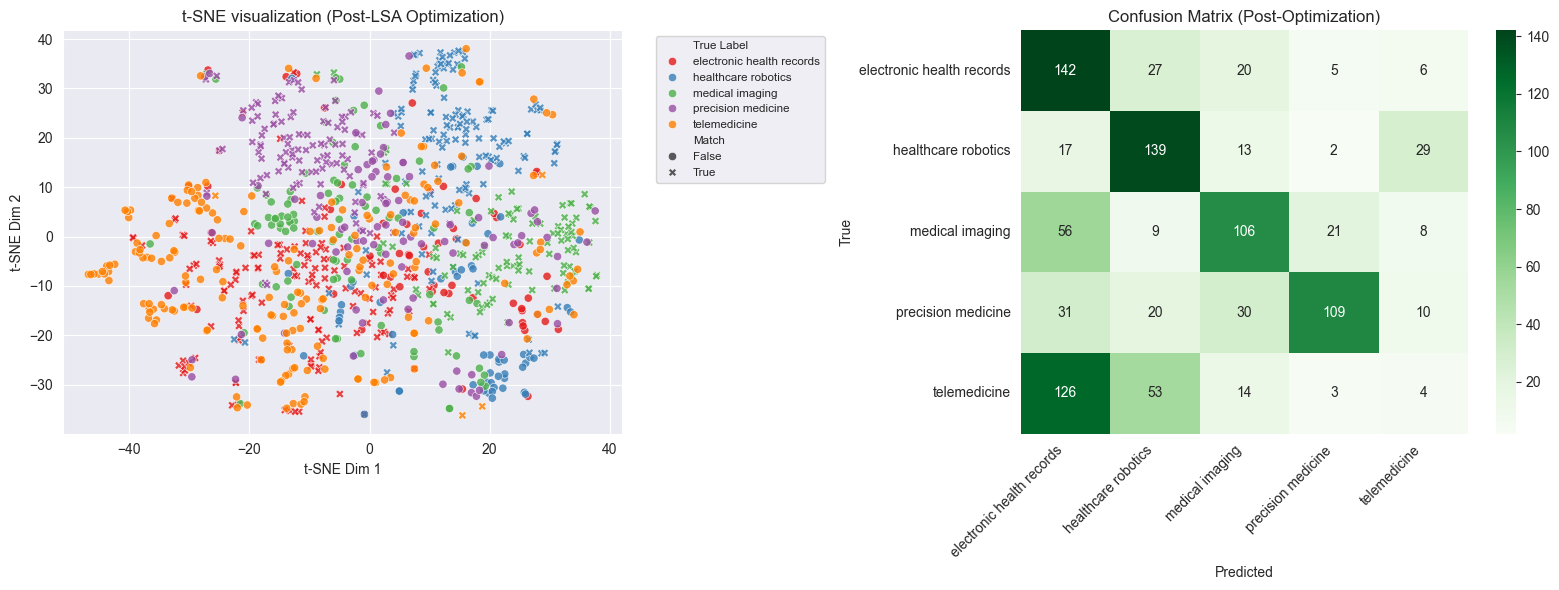

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, cohen_kappa_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import TSNE

# ----------------- 1. Data Reading and Basic Cleaning -----------------
df = pd.read_csv('../processed_data.csv')
docs = df['Cleaned_Content'].fillna('').str.replace(r'\bpad\b', '', regex=True).tolist()
true_labels = df['Label'].tolist()

unique_labels = sorted(list(set(true_labels)))
label_to_id = {l: i for i, l in enumerate(unique_labels)}
y_true = [label_to_id[l] for l in true_labels]

# ----------------- 2. Advanced Feature Engineering (TF-IDF + LSA) -----------------
# 2.1 Introduce "high-frequency noise words" found in error analysis as custom stop words
# These words appear in large numbers in all medical literature, interfering with clustering in specific subfields
custom_stop_words = list(CountVectorizer(stop_words='english').get_stop_words()) + \
                    ['patient', 'data', 'study', 'health', 'method', 'model',
                     'clinical', 'based', 'using', 'healthcare', 'care', 'result', 'analysis']

# Limit max_df to remove overly common words, increase min_df to remove extremely rare words
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=custom_stop_words, max_df=0.6, min_df=5)
X_tfidf = tfidf_vectorizer.fit_transform(docs)

# 2.2 Latent Semantic Analysis (LSA) - Dimensionality reduction using TruncatedSVD
# Reduce the 5000-dimensional sparse matrix to a 100-dimensional dense semantic vector space
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_lsa = svd.fit_transform(X_tfidf)

# ----------------- 3. K-means Clustering (Based on Semantic Vectors) -----------------
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20) # Increase n_init to avoid local optima
y_pred_clusters = kmeans.fit_predict(X_lsa)

# Hungarian algorithm to match labels
def match_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
    mapping = {col: row for col, row in zip(col_ind, row_ind)}
    y_pred_matched = [mapping[l] for l in y_pred]
    return np.array(y_pred_matched), mapping, cm

y_pred_matched, cluster_mapping, cm = match_labels(y_true, y_pred_clusters)

# ----------------- 4. Model Evaluation -----------------
sil_score = silhouette_score(X_lsa, y_pred_clusters)
kappa = cohen_kappa_score(y_true, y_pred_matched)

print(f"=== Post-Optimization Evaluation Metrics ===")
print(f"LSA Silhouette Score: {sil_score:.4f}")
print(f"LSA Kappa Score: {kappa:.4f}")

# ----------------- 5. Visualizations -----------------
plt.figure(figsize=(16, 6))

# Plot 1: t-SNE dimensionality reduction scatter plot (Based on optimized LSA vectors)
plt.subplot(1, 2, 1)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_lsa)
df_tsne = pd.DataFrame({
    't-SNE Dim 1': X_tsne[:,0],
    't-SNE Dim 2': X_tsne[:,1],
    'True Label': [unique_labels[i] for i in y_true],
    'Match': y_true == y_pred_matched
})
sns.scatterplot(data=df_tsne, x='t-SNE Dim 1', y='t-SNE Dim 2', hue='True Label', style='Match', palette='Set1', alpha=0.8)
plt.title('t-SNE visualization (Post-LSA Optimization)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Plot 2: Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_true, y_pred_matched), annot=True, fmt='d', cmap='Greens',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix (Post-Optimization)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('clustering_eval_optimized.png', dpi=300)
plt.show()